# EVALUATING AUTOENCODERS

The evaluation encompasses
* **Function recovery**. Can the autoencoder accurately recover time courses from reaction networks.
* **Insightful interpretation**. Does the autoencoder produce a low dimension representation that provides useful insights.

The initial focus is on function recovery. To gain insight into the effectiveness of autoencoders for this task, we start by considering synthetic time courses to investigate the ability of autoencoderes to recover functions similar to those used in rate laws of biological systems.

# Preliminaries

In [1]:
from autoencodersb import constants as cn
from autoencodersb.data_generator import DataGenerator
from autoencodersb.dataset_csv import DatasetCSV
from autoencodersb.polynomial_collection import PolynomialCollection
from autoencodersb.model_runner_pca import ModelRunnerPCA
from autoencodersb.model_runner_nn import ModelRunnerNN
from autoencodersb.autoencoder import Autoencoder
from autoencodersb.sequence import Sequence
from autoencodersb.model_runner_pca import ModelRunnerPCA
from autoencodersb.autoencoder import Autoencoder  # type: ignore
from autoencodersb.autoencoder_umap import AutoencoderUMAP # type: ignore
from autoencodersb.model_runner_umap import ModelRunnerUMAP # type: ignore
from autoencodersb.model_runner_pca import ModelRunnerPCA # type: ignore
import autoencodersb.utils as utils

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd
import tellurium as te
import torch
from typing import Optional
import umap

/Users/jlheller/home/Technical/repos/autoencodersb/asb/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Models

## Wolf

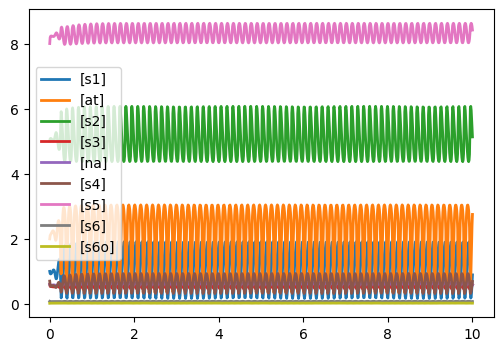

In [2]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(utils.getLocalURL(WOLF_URL))
WOLF_ARR = rr.simulate(0, 10, 1000)
rr.plot()
columns = [c[1:-1] if c != 'time' else c for c in WOLF_ARR.colnames]
WOLF_DF = pd.DataFrame(WOLF_ARR, columns=columns)
WOLF_DL = DataLoader(DatasetCSV(WOLF_DF), batch_size=int(0.1*len(WOLF_DF)))

## Schokker

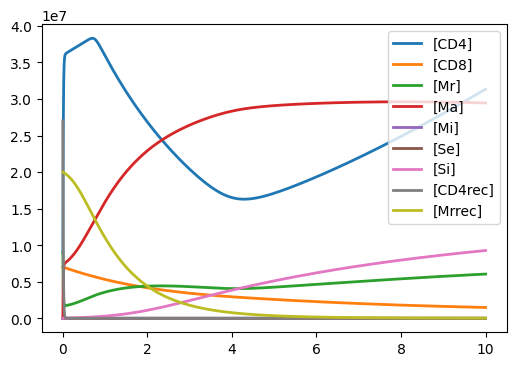

In [3]:
SCHOKKER_MODEL_NUM = 895
rr = te.loadSBMLModel(utils.getLocalURL(model_num=SCHOKKER_MODEL_NUM))
arr = rr.simulate(0, 10, 1000)
rr.plot()
columns = [c[1:-1] if c != 'time' else c for c in arr.colnames]

# Helpers

## plotModel

In [4]:
def plotModel(url, title="", eliminate_idxs=None):
    # Plots the model on BioModels and returns its data
    rr = te.loadSBMLModel(url)
    arr = rr.simulate(0, 10, 1000)
    columns = [c[1:-1] if c != 'time' else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    if eliminate_idxs is not None:
        idxs = set(range(arr.shape[1])) - set(eliminate_idxs)
        idx_arr = np.array(list(idxs))
        arr = arr[:, idx_arr]
    plt.plot(arr[:, 0], arr[:, 1:])
    plt.title(title)
    return df

## plotUMAP

In [5]:
def plotUMAP(arr, n_component: int = 2, start_idx: int = 1, title=""):
    # Ignores the first
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=n_component, random_state=42)
    embedding = reducer.fit_transform(arr[:, start_idx:])
    # Plot the results
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title(title)
    plt.show()
    return embedding

# Evaluation Data

## Synthetic data

Below we describe the data used to evaluate autoencoders.

The emphasis is on time series similar to those encountered in biological models. Our approach is to consider the functional form of common rate laws. These typically consist of a single term that is one of the following:

* A constant times the concentration of a floating species. This is a first order polynomal.
    * $A \rightarrow B;~ kA$.
* A constant times a the product of concentrations of two floatin species. This is a second order polynomial.
    * $A B \rightarrow C;~ k A B$
* An ratio of polynomials for Michaelis-Menten and Hill Equations
    * $A \rightarrow B; ~ \frac{v A^n}{(k + A^n)}$

We consider tree different time series for the floating species in a rate law
* Linear: $A = kt$, where $k$ is a fixed constant
* Exponential: $A = e^{-r t}$
* Exponential integeral: $A = 1 - e^{-r t}/r$

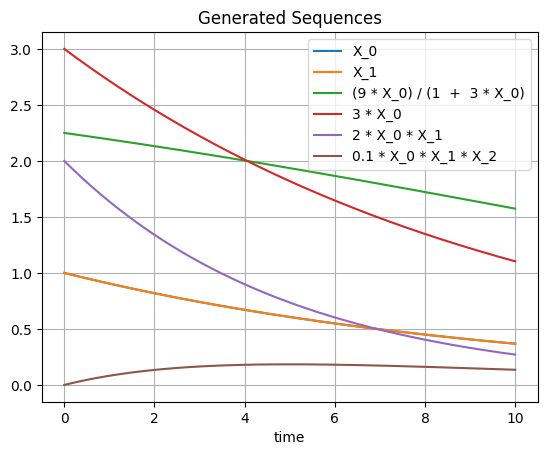

In [6]:
polynomial_collection = PolynomialCollection.make(
        is_mm_term=True,
        is_first_order_term=3,
        is_second_order_term=2,
        is_third_order_term=0.1)
num_point = 2000
end_time = 10
GENERATOR_TRAIN = DataGenerator(polynomial_collection=polynomial_collection,
        num_sample=num_point)
SEQUENCES = [Sequence(num_point=num_point, end_time=end_time, rate=0.1, seq_type=cn.SEQ_EXPONENTIAL),
             Sequence(num_point=num_point, end_time=end_time, rate=0.1, seq_type=cn.SEQ_EXPONENTIAL),
             Sequence(num_point=num_point, end_time=end_time, seq_type=cn.SEQ_LINEAR)]
GENERATOR_TRAIN.specifySequences(sequences=SEQUENCES)
GENERATOR_TRAIN.generate()
GENERATOR_TRAIN.plotGeneratedData(x_column="X_2")
TRAIN_DF = GENERATOR_TRAIN.data_df
TRAIN_DL = GENERATOR_TRAIN.data_dl

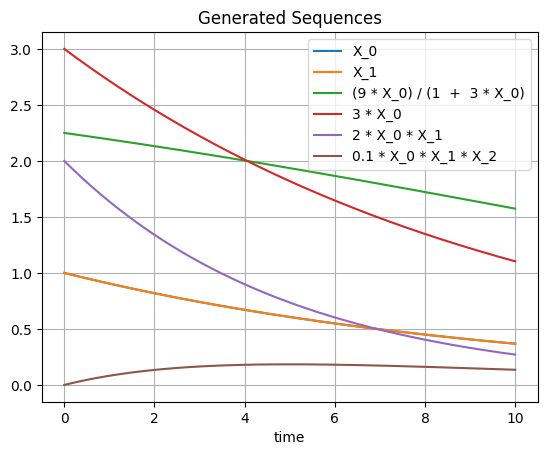

In [7]:
GENERATOR_TEST = DataGenerator(polynomial_collection=polynomial_collection,
        num_sample=num_point)
GENERATOR_TEST.specifySequences(sequences=SEQUENCES)
GENERATOR_TEST.generate()
GENERATOR_TRAIN.plotGeneratedData(x_column="X_2")
TEST_DF = GENERATOR_TEST.data_df
TEST_DL = GENERATOR_TEST.data_dl

# Autoencoder

In [8]:
NUM_INPUT_FEATURE = 7
NUM_OUTPUT_FEATURE = 1
NUM_EPOCH = 10000

MODEL = Autoencoder(layer_dimensions=[NUM_INPUT_FEATURE, 10*NUM_INPUT_FEATURE,
        10*NUM_OUTPUT_FEATURE, NUM_OUTPUT_FEATURE])

if False:
    runner = ModelRunnerNN(model=MODEL, num_epoch=NUM_EPOCH,
                    learning_rate=1e-5, is_normalized=True,
                    max_fractional_error=0.1)
    runner_result_fit = runner.fit(TRAIN_DL)
    runner.plotEvaluate(TEST_DL)

# Models

## Wolf Model

### Model

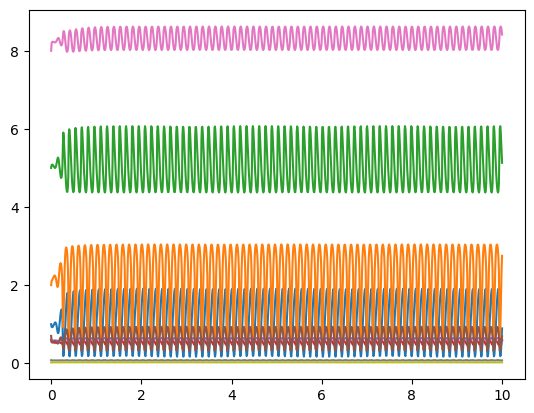

In [9]:
plt.plot(WOLF_ARR[:, 0], WOLF_ARR[:, 1:])

### PCA

In [10]:
runner = ModelRunnerPCA.makeFromSBML(WOLF_URL, num_epoch=500)
_ = runner.plotSimulationFit(antimony_model="Wolf")

TypeError: plotSimulationFit() got an unexpected keyword argument 'antimony_model'

### UMAP

In [ ]:
for n_components in range(1, 6):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=n_components)
    embedding_arr = reducer.fit_transform(WOLF_DF.values)
    _, ax = plt.subplots(1, 1)
    for n in range(embedding_arr.shape[1]):
        ax.plot(range(embedding_arr.shape[0]), embedding_arr[:, n])
    ax.set_title(f"n={n}")

### UMAP Decoder

In [ ]:
WOLF_RUNNER = plotSimulationFit(WOLF_DF, num_epoch=1000, num_output_feature=2, offset=100)

In [ ]:
_ = plotSimulationFit(WOLF_DF, num_epoch=1000, num_output_feature=3, offset=100)

In [ ]:
runner = ModelRunnerUMAP.makeFromSBML(WOLF_URL, num_epoch=500)
_ = runner.plotSimulationFit(antimony_model="Wolf")

In [ ]:
runner = ModelRunnerUMAP.makeFromSBML(WOLF_URL, num_epoch=5000)
_ = runner.plotSimulationFit(antimony_model="Wolf")

## Schokker

In [ ]:
url = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2004140001/3/Garde2020.xml"
runner = ModelRunnerUMAP.makeFromSBML(url, num_epoch=5000)
_ = runner.plotSimulationFit(antimony_model="Cell Cycle")

## Twenty step mass action

In [ ]:
TWENTY_STEP_MODEL = """
// Twenty Step Mass-Action Linear Chain

J1: $Xo -> S1; k10*Xo - k11*S1;
J2: S1 -> S2; k20*S1 - k21*S2;
J3: S2 -> S3; k30*S2 - k31*S3;
J4: S3 -> S4; k40*S3 - k41*S4;
J5: S4 -> S5; k50*S4 - k51*S5;
J6: S5 -> S6; k60*S5 - k61*S6;
J7: S6 -> S7; k70*S6 - k71*S7;
J8: S7 -> S8; k80*S7 - k81*S8;
J9: S8 -> S9; k90*S8 - k91*S9;
J10: S9 -> S10; k100*S9 - k101*S10;
J11: S10 -> S11; k110*S10 - k111*S11;
J12: S11 -> S12; k120*S11 - k121*S12;
J13: S12 -> S13; k130*S12 - k131*S13;
J14: S13 -> S14; k140*S13 - k141*S14;
J15: S14 -> S15; k150*S14 - k151*S15;
J16: S15 -> S16; k160*S15 - k161*S16;
J17: S16 -> S17; k170*S16 - k171*S17;
J18: S17 -> S18; k180*S17 - k181*S18;
J19: S18 -> S19; k190*S18 - k191*S19;
J20: S19 -> $X1; k200*S19 - k201*X1;

k10 = 4.32;  k11 = 0.36
k20 = 0.37;  k21 = 0.46
k30 = 5.01;  k31 = 0.86
k40 = 2.22;  k41 = 0.85
k50 = 1.29;  k51 = 0.83
k60 = 2.25;  k61 = 0.37
k70 = 0.9;  k71 = 0.25
k80 = 0.28;  k81 = 0.75
k90 = 2.81;  k91 = 0.41
k100 = 2.30;  k101 = 0.05
k110 = 0.50;  k111 = 0.17
k120 = 0.90;  k121 = 0.70
k130 = 0.98;  k131 = 0.46
k140 = 4.22;  k141 = 0.75
k150 = 0.71;  k151 = 0.44
k160 = 1.33;  k161 = 0.11
k170 = 0.33;  k171 = 0.21
k180 = 2.21;  k181 = 0.67
k190 = 3.84;  k191 = 0.45
k200 = 4.19;  k201 = 0.24

Xo = 10.00
X1 = 0

S1 = 0; S2 = 0; S3 = 0; S4 = 0;
S5 = 0; S6 = 0; S7 = 0; S8 = 0;
S9 = 0; S10 = 0; S11 = 0; S12 = 0;
S13 = 0; S14 = 0; S15 = 0; S16 = 0;
S17 = 0; S18 = 0; S19 = 0;
"""

In [ ]:
runner = ModelRunnerUMAP.makeFromSBML(TWENTY_STEP_MODEL, num_epoch=5000)
_ = runner.plotSimulationFit(antimony_model="Twenty Step")

In [ ]:
runner = ModelRunnerPCA.makeFromSBML(TWENTY_STEP_MODEL, num_epoch=5000)
_ = runner.plotSimulationFit(antimony_model="Twenty Step", is_plot_original=False)

**Notes**
1. Different phases show up as deviations from the single line.
2. 

# TO DO

1. Test Hill ratio terms
2. Select synthetic data for evaluations
3. Evaluate w.r.t. PCA